In [1]:
import re
import string
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Embedding, Bidirectional

In [2]:
# Text preprocessing function
def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

str_punc = string.punctuation.replace(',', '').replace("'",'')

In [3]:
# Read dataset & Preprocess text
dataset = pd.read_csv('../input/learning-style-vak/dataset.csv')

X = dataset['Sentence'].apply(clean)
y = dataset['Type']

<AxesSubplot:>

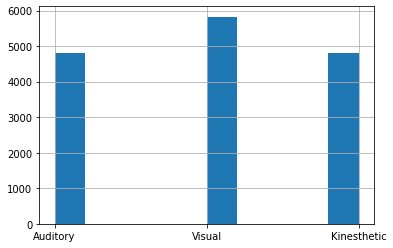

In [4]:
# Visualize classes counts
dataset['Type'].hist()

In [5]:
# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)


text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)
sequences_train = tokenizer.texts_to_sequences(text_train)
sequences_test = tokenizer.texts_to_sequences(text_test)
X_train = pad_sequences(sequences_train, maxlen=48, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=48, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary Size = {vocabSize}")

Vocabulary Size = 26767


In [6]:
# Read GloVE embeddings

path_to_glove_file = '../input/glove-global-vectors-for-word-representation/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 23775 words (2991 misses)


In [7]:
# Build neural network architecture

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(128, dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 200)           5353400   
_________________________________________________________________
lstm (LSTM)                  (None, 48, 256)           467968    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 6,018,875
Trainable params: 665,475
Non-trainable params: 5,353,400
_________________________________________________________________


In [8]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    batch_size=64,
                    epochs=10)

Epoch 1/10
194/194 [==============================] - 79s 383ms/step - loss: 0.8517 - accuracy: 0.5981 - val_loss: 0.4918 - val_accuracy: 0.8136
Epoch 2/10
194/194 [==============================] - 77s 395ms/step - loss: 0.4781 - accuracy: 0.8080 - val_loss: 0.3182 - val_accuracy: 0.8751
Epoch 3/10
194/194 [==============================] - 76s 392ms/step - loss: 0.2730 - accuracy: 0.8911 - val_loss: 0.1744 - val_accuracy: 0.9294
Epoch 4/10
194/194 [==============================] - 77s 397ms/step - loss: 0.1773 - accuracy: 0.9253 - val_loss: 0.1205 - val_accuracy: 0.9492
Epoch 5/10
194/194 [==============================] - 79s 405ms/step - loss: 0.1260 - accuracy: 0.9446 - val_loss: 0.1110 - val_accuracy: 0.9553
Epoch 6/10
194/194 [==============================] - 76s 394ms/step - loss: 0.1057 - accuracy: 0.9513 - val_loss: 0.1084 - val_accuracy: 0.9557
Epoch 7/10
194/194 [==============================] - 79s 410ms/step - loss: 0.1000 - accuracy: 0.9527 - val_loss: 0.0976 - val_ac

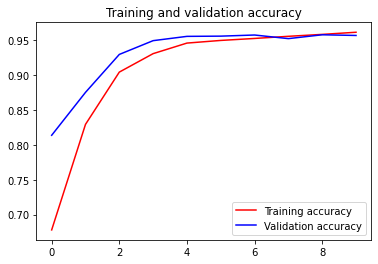

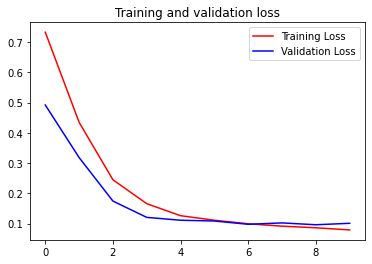

In [9]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
model.evaluate(X_test, y_test, verbose=1)

97/97 [==============================] - 2s 24ms/step - loss: 0.1009 - accuracy: 0.9566


[0.1008862853050232, 0.9566342830657959]

In [11]:
# Classify custom sample

sentences = ["Can you imagine how this idea's gonna change the education system!", # Visual
             "Brilliant! I can't wait to hear the news about this change!", # Auditory
             "Chill out guys, nothing's gonna change, we have to study hard to succeed" # Kinesthetic
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=48, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

Can you imagine how this idea's gonna change the education system!
Visual : 0.9996569156646729


Brilliant! I can't wait to hear the news about this change!
Auditory : 0.9995218515396118


Chill out guys, nothing's gonna change, we have to study hard to succeed
Kinesthetic : 0.961560070514679




In [12]:
# import pickle

# with open('tokenizer.pickle', 'wb') as f:
#     pickle.dump(tokenizer, f)
    
# with open('labelEncoder.pickle', 'wb') as f:
#     pickle.dump(le, f)
    
    
# model.save('LearningStyleClassifier.h5')